# Train a Machine Learning Model to Classify SMSs as Spam or Not Spam

### Training Dataset (and others) can be found at Kaggle.com
- **I used a csv dataset from https://www.kaggle.com/datasets/uciml/sms-spam-collection-dataset/data which contains a collection of SMSs.**
- **It contains one set of SMS messages in English of 5,572 messages, tagged according to being ham (legitimate) or spam.**

### Text Embedding Model: OpenAI's “text-embedding-3-small” model
- **See https://platform.openai.com/docs/guides/embeddings for more information about their text embedding models.**


________________________________________________
________________________________________________

## Step 1:
- Import the OpenAI library (you may have to install it first).
- Download the csv data file from Kaggle (I've already downloaded and saved the csv file (in the same folder as my notebook) as **spam.csv**).
- Ensure you have an API Key to access OpenAI's text embedding models (I've already created a key).
- Ensure that you have a credit balance on your OpenAI account.

In [1]:
# pip install openai
import openai
#I've stored my API key in a separate config.py file.
from config import api_key 

_________________________________________
_________________________________________

## Step 2: Import the other libraries needed to train our Spam Classifier
- You may have to install these libraries if you don't already have them.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay

_________________________________
_________________________________

## Step 3: Load the csv data into a dataframe and prepare the data for training the model
- Load the data into a dataframe. I've called my dataframe 'spam_data'.
- Inspect the dataframe
- Do any data cleanup as may be required

In [3]:
# Load the dataset to inspect it
csv_file = "spam.csv"
spam_data = pd.read_csv(csv_file, encoding='latin-1')

# Display basic information about the dataset (top and bottome rows) to understand its structure
spam_data

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN
...,...,...,...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...,NaN,NaN,NaN
5568,ham,Will Ì_ b going to esplanade fr home?,NaN,NaN,NaN
5569,ham,"Pity, * was in mood for that. So...any other s...",NaN,NaN,NaN
5570,ham,The guy did some bitching but I acted like i'd...,NaN,NaN,NaN


In [4]:
spam_data.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   v1          5572 non-null   object
 1   v2          5572 non-null   object
 2   Unnamed: 2  50 non-null     object
 3   Unnamed: 3  12 non-null     object
 4   Unnamed: 4  6 non-null      object
dtypes: object(5)
memory usage: 217.8+ KB


### Observations

- v1: Labels indicating whether a message is 'ham' (not spam) or 'spam'.
- v2: The text of the SMS message itself.

There are also three additional columns (Unnamed: 2, Unnamed: 3, Unnamed: 4) that mostly contain NaN values. These might represent misplaced data or could be artefacts from the dataset formatting.

**Recommendations for Data Preparation:**
- **Remove Unnecessary Columns:** We should drop the columns Unnamed: 2, Unnamed: 3, and Unnamed: 4 as they contain very little data. It will therefore not be useful information for our task and removing these columns will also simplify our dataset.
- **Rename Columns:** Renaming v1 to label and v2 to message will make the DataFrame more readable.
- **Check for Missing Data:** It's good to check if there are any NaN values in the label and message columns that need addressing. In our case, the NaN values are all in the columns we will drop.
- **Text Normalization:** This is always important. **However, we are not** going to convert text to lowercase, remove punctuation, or eliminate stopwords (you would do this if you are training an embedding model), etc.. OpenAI's models are trained on large datasets that include both lowercase and uppercase text. This makes them robust to different text formats.

In [5]:
# Cleaning the dataset according to the recommendations above:

# Dropping unnecessary columns
spam_data_cleaned = spam_data.drop(columns=['Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'])

# Renaming columns
spam_data_cleaned.rename(columns={'v1': 'label', 'v2': 'message'}, inplace=True)

# Check for any NaN values in the label and message columns
nan_counts = spam_data_cleaned.isna().sum()

# Show cleaned dataset and NaN counts
spam_data_cleaned.head(), nan_counts

(  label                                            message
 0   ham  Go until jurong point, crazy.. Available only ...
 1   ham                      Ok lar... Joking wif u oni...
 2  spam  Free entry in 2 a wkly comp to win FA Cup fina...
 3   ham  U dun say so early hor... U c already then say...
 4   ham  Nah I don't think he goes to usf, he lives aro...,
 label      0
 message    0
 dtype: int64)

### View the cleaned-up dataframe contents

In [6]:
spam_data_cleaned.head(3)

,label,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...


### Optional: Change the display style if you want a better visualization of the dataframe

In [7]:
# Set the maximum width of columns in characters
pd.set_option('display.max_colwidth', None)  # None means no truncation, or you can set a specific large number

# Set the text in DataFrame to be left-aligned
pd.set_option('display.colheader_justify', 'left')

# Apply a style to the DataFrame for left alignment in display
styled_df = spam_data_cleaned.style.set_properties(**{'text-align': 'left'})

# Display the styled DataFrame
styled_df

In [8]:
type(styled_df)
# type(spam_data_cleaned)

pandas.io.formats.style.Styler

________________________________
________________________________

## Step 4: Do some quick tests to see that you can access and use the OpenAI text embedding model
- To get an embedding, send your text string to the embeddings API endpoint, along with the embedding model name (e.g. **"text-embedding-3-small"**). The response will contain an embedding vector (list of floating point numbers), which you can extract, save in a vector database, and use for many different use cases. In our case, we'll not set up a vector database. We'll stick to a dataframe:

In [9]:
# Always follow OpenAI's latest documentation:
client = openai.OpenAI(api_key = api_key)
response = client.embeddings.create(
        input="Cybersecurity",
        model="text-embedding-3-small"
    )
print(response.data[0].embedding)

[0.00695241242647171, -0.008413705974817276, 0.030255869030952454, 0.02407594583928585, 0.04840938746929169, -0.009186196140944958, 0.003305614460259676, 0.04410919174551964, -0.004132823087275028, 0.02623891830444336, 0.03926825523376465, -0.025775425136089325, -0.02922588214278221, -0.05845176428556442, -0.005668147467076778, -0.00469609722495079, -0.06962712109088898, -0.0044128503650426865, 0.004364570137113333, 0.010673240758478642, 0.04928487911820412, 0.011490792967379093, 0.033268582075834274, 0.03401532024145126, -0.01899038627743721, 0.019029010087251663, 0.033629074692726135, -0.010538054630160332, 0.01805052161216736, -0.0031350229401141405, 0.046272166073322296, -0.05422881618142128, -0.015552803874015808, -0.0045351614244282246, 0.01329970732331276, 0.03929400444030762, -0.010467243380844593, 0.010344931855797768, 0.020380867645144463, 0.044701434671878815, -0.015282432548701763, 0.019183507189154625, -0.02232496812939644, 0.05227183923125267, -0.01372457668185234, -0.020

### For fun, let's create some text embeddings and do similarity checks

In [10]:
# Function to fetch embeddings
openai.api_key = api_key
def get_embedding(text):
    client = openai.OpenAI(api_key = api_key)
    response = openai.embeddings.create(
        input=text,
        model="text-embedding-3-small"
    )
    return np.array(response.data[0].embedding)

# Embeddings
embed_cybersecurity = get_embedding("Cybersecurity")
embed_network_security = get_embedding("Network Security")
embed_pancake = get_embedding("Pancake")

# Function to calculate cosine similarity
def cosine_similarity(vec1, vec2):
    dot_product = np.dot(vec1, vec2)
    norm_vec1 = np.linalg.norm(vec1)
    norm_vec2 = np.linalg.norm(vec2)
    return dot_product / (norm_vec1 * norm_vec2)

# Calculating similarities
similarity_cybersecurity_network = cosine_similarity(embed_cybersecurity, embed_network_security)
similarity_cybersecurity_pancake = cosine_similarity(embed_cybersecurity, embed_pancake)

print("Similarity between 'Cybersecurity' and 'Network Security':", similarity_cybersecurity_network)
print("Similarity between 'Cybersecurity' and 'Pancake':", similarity_cybersecurity_pancake)

Similarity between 'Cybersecurity' and 'Network Security': 0.6221268984362717
Similarity between 'Cybersecurity' and 'Pancake': 0.10606601448220364


_________________________________
_________________________________

# Step 5: Use the text embedding model to convert your SMS data into vectors!
## Caution: Only run the code below once. Then store your embedding data into a csv file or database for later reuse!
## Running the code below can take some time, and you will incur a cost each time you use the embedding model.

In [ ]:
def generate_embeddings(texts, api_key):
    client = openai.OpenAI(api_key=api_key)
    embeddings = []
    for text in texts:
        response = client.embeddings.create(
            input=text, 
            model="text-embedding-3-small"
        )
        # Correctly accessing the response object
        embeddings.append(response.data[0].embedding)
    return embeddings

# Generate embeddings for all messages
embeddings = generate_embeddings(spam_data_cleaned['message'].tolist(), api_key)

# Create DataFrame with embeddings
column_names = ["embedding_" + str(i) for i in range(1536)]  # Assuming 1536 dimensions from the model
df_embeddings = pd.DataFrame(embeddings, columns=column_names)
df_embeddings['label'] = spam_data_cleaned['label']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(df_embeddings.drop('label', axis=1), df_embeddings['label'], test_size=0.2, random_state=42)

# Now X_train, X_test, y_train, and y_test are ready for model training and evaluation

# Save the contents of df_embeddings to a csv file for later use:
df_embeddings.to_csv('sms_embeddings_backup.csv', index=False)

## Other Embedding Models:
- **Word2Vec (Word to Vector):** Transforms words into fixed-dimensional vectors based on their context in a specific corpus of text
- **GloVe (Global Vectors):** Loks at how often words co-occur across the entire vocabulary.
- **FastText:** breaks words down into smaller components like syllables or letter combinations (n-grams).
- **BERT (Bidirectional Encoder Representations from Transformers):** understands the context of a word bidirectionally, by paying attention to both the left and right sided of a word in a sentence.
- **Doc2Vec (Document to Vector):** An extension of Word2Vec that can embed entire documents or paragraphs.
- **Universal Sentence Encoder (USE):** Encodes sentences or paragraphs into fixed-size vectors.

### Assuming you have saved your vector embeddings (using the code above) to a csv file, let's now reload that data and prepare to train our machine learning model (classifier).

In [11]:
df_embeddings_backup = pd.read_csv('sms_embeddings_backup.csv')
df_embeddings_backup.head(3)

,embedding_0,embedding_1,embedding_2,embedding_3,embedding_4,embedding_5,embedding_6,embedding_7,embedding_8,embedding_9,...,embedding_1527,embedding_1528,embedding_1529,embedding_1530,embedding_1531,embedding_1532,embedding_1533,embedding_1534,embedding_1535,label
0,-0.011584,0.015810,-0.017551,-0.014157,-0.071270,-0.058155,0.023791,0.018771,-0.026714,-0.057697,...,-0.012315,0.017525,0.020995,0.027959,0.013319,0.019305,0.021986,-0.006850,0.000139,ham
1,0.062310,0.004907,0.009618,0.041285,0.016471,0.021203,-0.012193,-0.011859,-0.046792,-0.014219,...,-0.016293,-0.035398,0.019975,0.035660,0.040094,0.020714,-0.021167,-0.037996,0.014791,ham
2,-0.005321,-0.017714,0.059229,-0.022827,-0.008559,-0.027123,-0.002243,0.044850,-0.027201,0.016300,...,0.007423,0.005574,0.039737,-0.025955,0.002675,-0.027694,0.006988,0.019233,0.017078,spam


_______________________________
_______________________________

## Train the Spam Classifier

In [12]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(df_embeddings_backup.drop('label', axis=1), df_embeddings_backup['label'], test_size=0.2, random_state=42)

In [13]:
# Check your training set. 
X_train

,embedding_0,embedding_1,embedding_2,embedding_3,embedding_4,embedding_5,embedding_6,embedding_7,embedding_8,embedding_9,...,embedding_1526,embedding_1527,embedding_1528,embedding_1529,embedding_1530,embedding_1531,embedding_1532,embedding_1533,embedding_1534,embedding_1535
1978,0.029612,0.043706,-0.069668,0.017441,-0.006086,-0.002881,0.022131,0.003931,0.009440,0.006944,...,-0.013573,-0.018589,0.010860,0.017502,0.025116,-0.000050,-0.022530,-0.001372,-0.026784,-0.025672
3989,0.039462,-0.055224,0.025769,0.036873,-0.019576,-0.000387,0.023517,0.061361,-0.016410,-0.029076,...,-0.008578,0.020097,0.026627,-0.000094,-0.010006,0.007487,-0.017958,0.011561,0.030033,-0.009183
3935,0.040620,-0.018699,0.028650,0.017906,-0.002226,0.020384,0.021884,0.092839,0.010056,0.016555,...,0.001345,-0.017472,0.038811,0.020546,0.007745,-0.019207,0.001444,-0.003776,-0.005514,-0.002480
4078,0.001870,-0.004188,-0.030621,0.005145,0.000733,0.019830,-0.003468,0.055934,-0.043165,0.052729,...,0.000757,0.016963,-0.044116,-0.024625,0.043390,0.010641,-0.021032,0.022534,0.016963,0.016337
4086,0.015200,-0.018024,0.013840,0.007519,-0.019044,-0.049888,0.003665,0.062575,0.029395,-0.043353,...,-0.012834,0.049770,-0.012679,0.018009,-0.016605,0.050805,-0.008827,-0.032204,0.001163,0.014964
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3772,-0.012782,-0.026929,-0.039419,-0.016106,-0.032256,-0.030488,0.010459,-0.005557,0.007885,-0.036666,...,-0.021478,-0.001121,-0.027533,-0.013386,0.038591,0.032570,-0.022541,-0.010963,0.004066,-0.002163
5191,0.026796,-0.007993,-0.041911,-0.028392,-0.041259,-0.010956,-0.013205,0.024862,0.004250,-0.004365,...,0.003679,0.038671,0.015599,0.023241,-0.023991,0.048320,-0.003709,0.014765,-0.006983,-0.000349
5226,0.065759,-0.034094,0.013380,0.017594,-0.011988,-0.016594,-0.004434,0.042879,-0.040831,-0.035332,...,0.000429,0.014464,-0.016487,-0.019904,0.020999,0.012857,0.002088,0.019154,0.020844,-0.009404
5390,-0.014606,0.013743,-0.028760,0.044467,-0.011070,0.011342,0.003157,0.013730,-0.009034,0.002312,...,-0.046696,0.024329,-0.012483,-0.014579,0.014911,0.027195,-0.004338,-0.022114,-0.012987,0.043910


In [14]:
# Check your training set. 
y_train

1978     ham
3989    spam
3935     ham
4078     ham
4086    spam
        ... 
3772     ham
5191     ham
5226     ham
5390     ham
860      ham
Name: label, Length: 4457, dtype: object

In [15]:
# Create the Random Forest classifier
clf = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the classifier
clf.fit(X_train, y_train)

# Predict on the test set
y_pred = clf.predict(X_test)

# Evaluate the classifier
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:")
print(classification_report(y_test, y_pred))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

Accuracy: 0.979372197309417
Classification Report:
              precision    recall  f1-score   support

         ham       0.98      1.00      0.99       965
        spam       1.00      0.85      0.92       150

    accuracy                           0.98      1115
   macro avg       0.99      0.92      0.95      1115
weighted avg       0.98      0.98      0.98      1115

Confusion Matrix:
[[965   0]
 [ 23 127]]


## Optional: Improve the visualisation/display of the Confusion Matrix

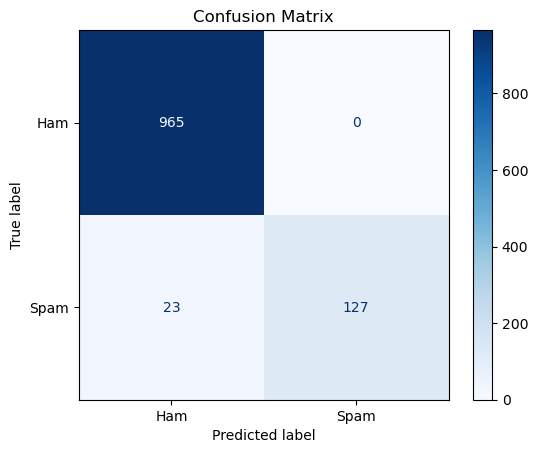

In [16]:
# Assuming y_test are the true labels and y_pred are the labels predicted by the model
cm = confusion_matrix(y_test, y_pred)

# Initialize the ConfusionMatrixDisplay object with the confusion matrix
cmd = ConfusionMatrixDisplay(cm, display_labels=['Ham', 'Spam'])

# Plot the matrix
cmd.plot(cmap=plt.cm.Blues, values_format='.0f')
plt.title('Confusion Matrix')
plt.show()

## Optional: Reduce the dimensionality of the 1536-dimensional vectors to 2, and plot on a 2D graph.

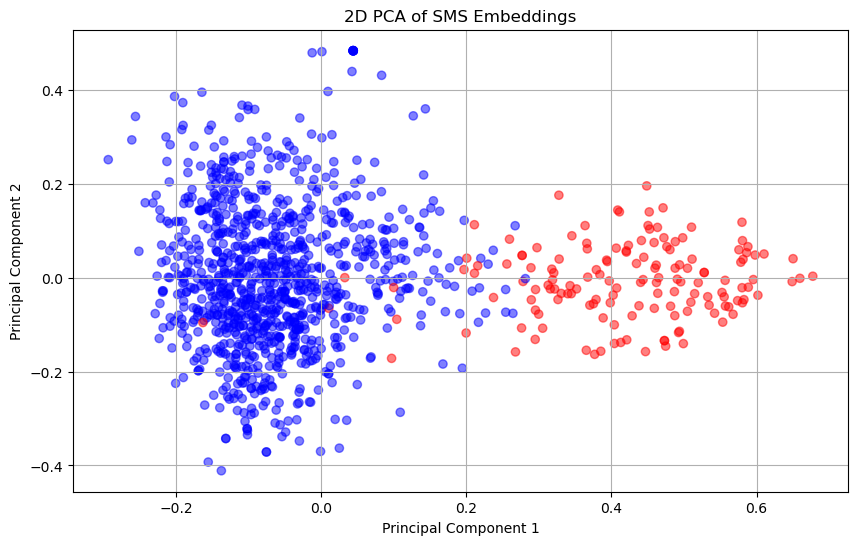

In [17]:
# Apply PCA to reduce to two dimensions
pca = PCA(n_components=2)
X_test_reduced = pca.fit_transform(X_test)

# Convert y_test to colors: 'spam' will be red, 'ham' will be blue
colors = ['red' if label == 'spam' else 'blue' for label in y_test]

# Create a scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(X_test_reduced[:, 0], X_test_reduced[:, 1], c=colors, alpha=0.5, marker='o')
plt.title('2D PCA of SMS Embeddings')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.grid(True)
plt.show()